# Machine Learning for Complete Intersection Calabi-Yau 3-folds

Harold Erbin and Riccardo Finotello

_Physics Department_

_Università degli Studi di Torino and I.N.F.N. - sezione di Torino_

_via Pietro Giuria 1, I-10125 Torino, Italy_

---
---

In this notebook we perform an Exploratory Data Analysis (EDA) on the prepared datasets (run the [previous notebook](./cicy3_tidy.ipynb) to download and tidy the datasets).

In [1]:
%load_ext autoreload
%autoreload 2

## Exploratory Data Analysis

We perform the EDA on the two datasets (NB: they contain the same configuration matrices, written in a different way).

In [2]:
import pandas as pd

df_o = pd.read_csv('./data/cicy3o_tidy.csv')
df_f = pd.read_csv('./data/cicy3f_tidy.csv')

### Distribution of the Labels

We study the distribution of the labels in the two datasets (they are the same, thus we will use the original dataset).

In [3]:
labels = df_o[['h11', 'h21']]
labels.describe()

,h11,h21
count,7890.000000,7890.000000
mean,7.419772,28.744740
std,2.250891,8.577282
min,0.000000,0.000000
25%,6.000000,23.000000
50%,7.000000,27.000000
75%,9.000000,33.000000
max,19.000000,101.000000


In [4]:
# save the labels to file for later use
labels.to_csv('./data/labels.csv', index=False)
labels['h11'].to_csv('./data/h11.csv', index=False)
labels['h21'].to_csv('./data/h21.csv', index=False)

Since the scales involved are different, we plot the distributions in log scales for comparison:

In [5]:
!python3 ./scripts/lab_dist.py

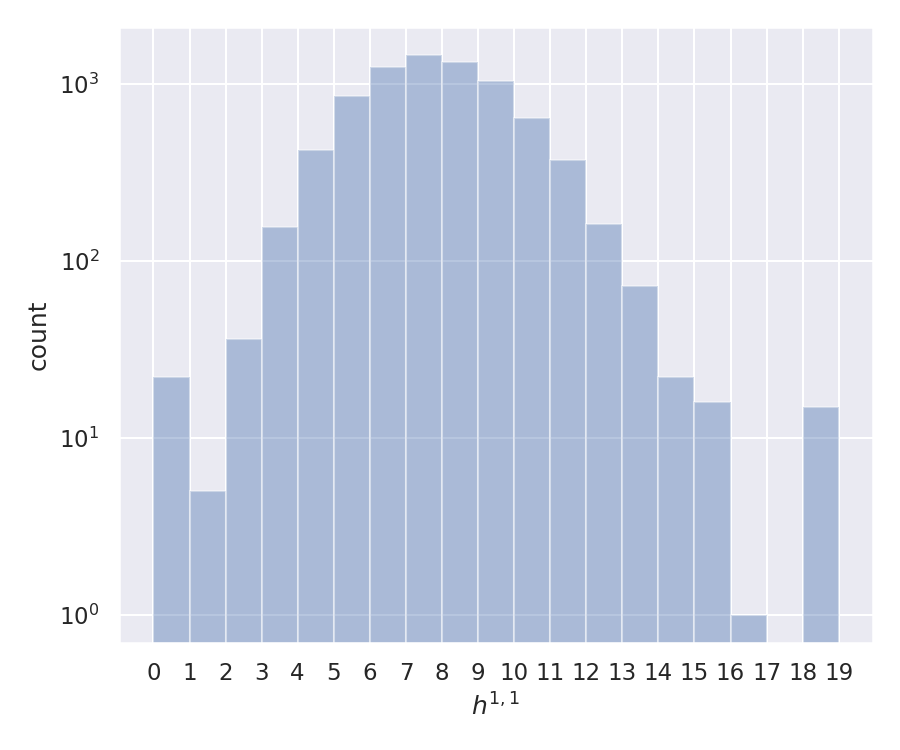

In [6]:
from IPython.display import Image
Image('./img/lab_h11_dist.png', width=480)

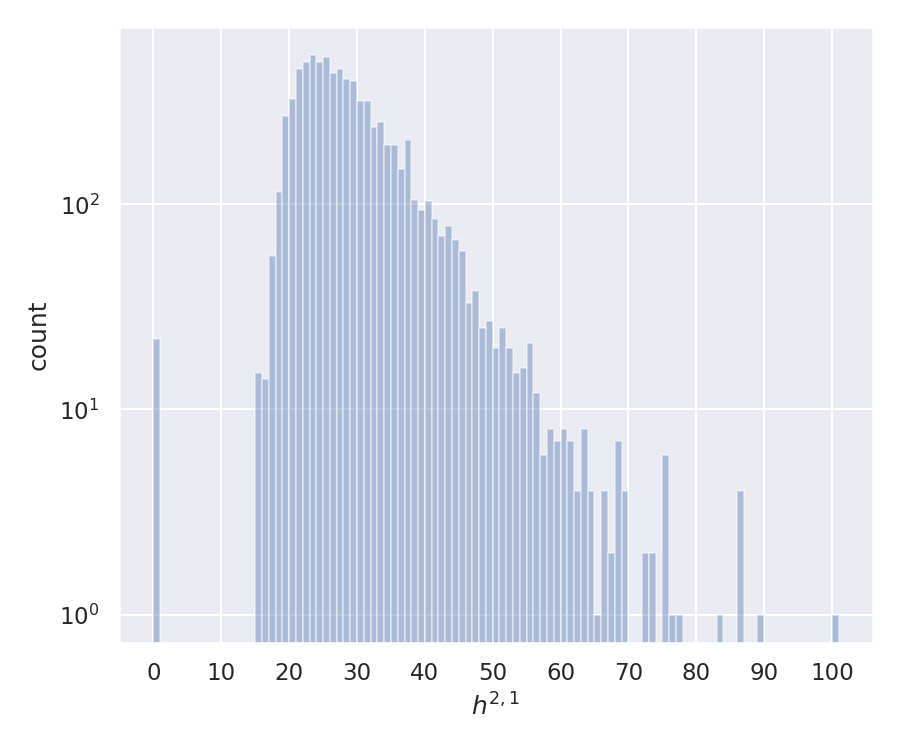

In [7]:
from IPython.display import Image
Image('./img/lab_h21_dist.png', width=480)

### Correlation Matrix

We then analyse the correlation between every variable and the labels in the datasets:

In [8]:
!python3 ./scripts/corr_mat.py

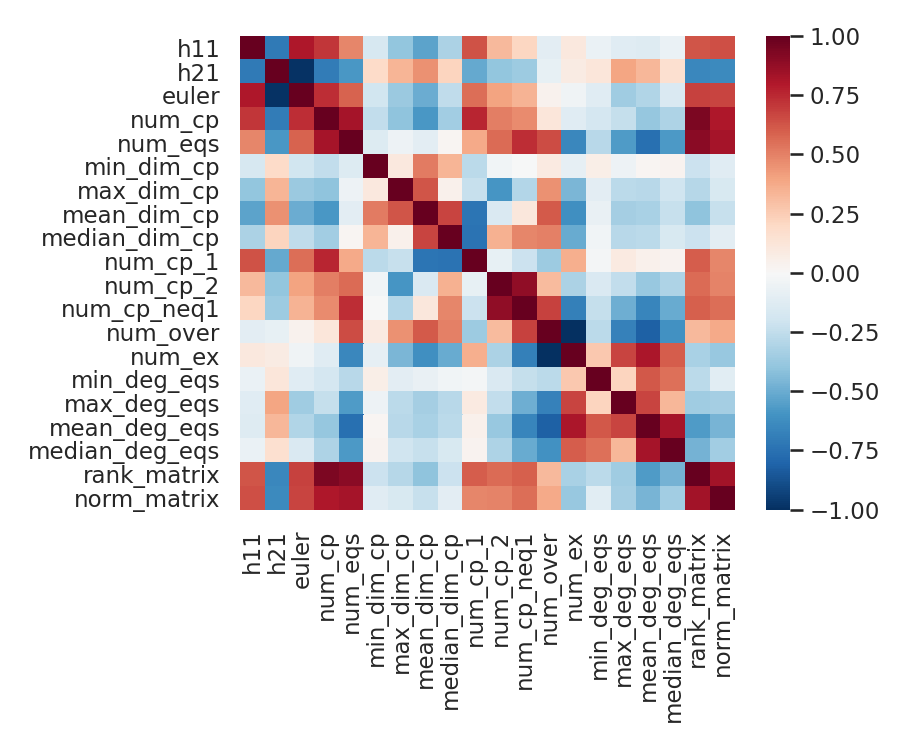

In [9]:
from IPython.display import Image

# display corr. mat. for the original dataset
Image('./img/corr_mat_orig.png', width=480)

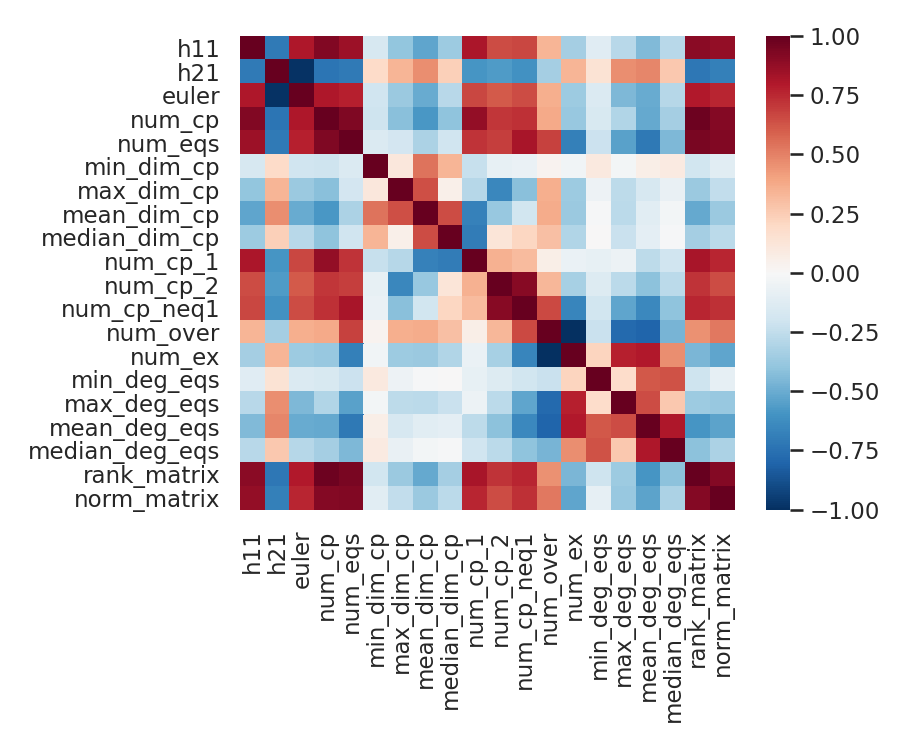

In [10]:
from IPython.display import Image

# display corr. mat. for the favourable dataset
Image('./img/corr_mat_fav.png', width=480)

### Scatter Plot of the Features

We show the distribution of the features in a scatter plot.

In [11]:
!python3 ./scripts/scat_plot.py

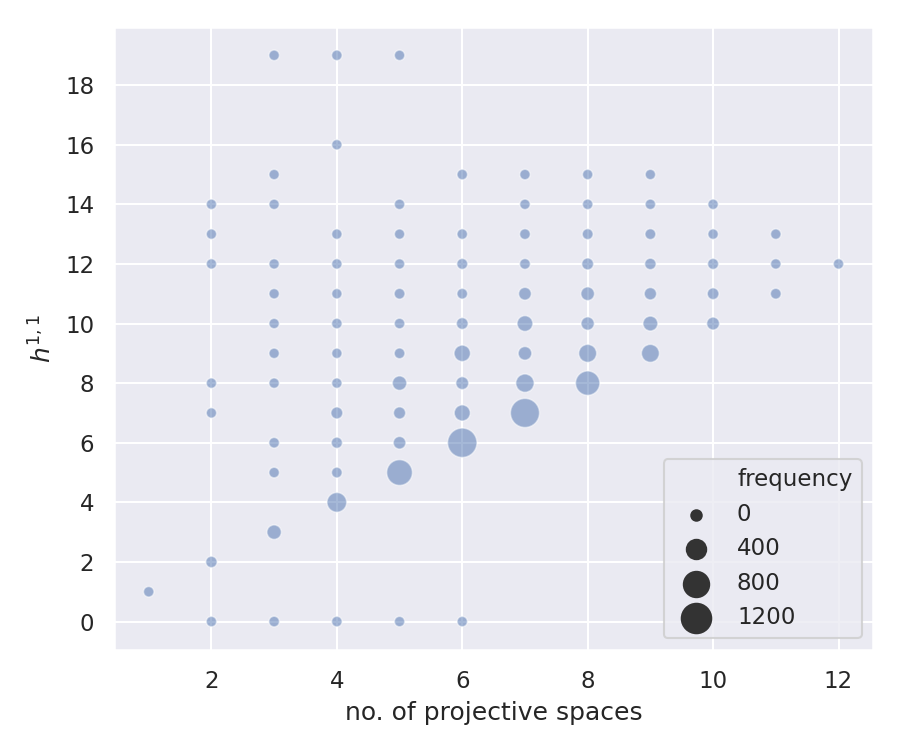

In [12]:
from IPython.display import Image

# display the linear relation between h11 and m in the orig. dataset
Image('./img/scat_num_cp_h11_orig.png', width=480)

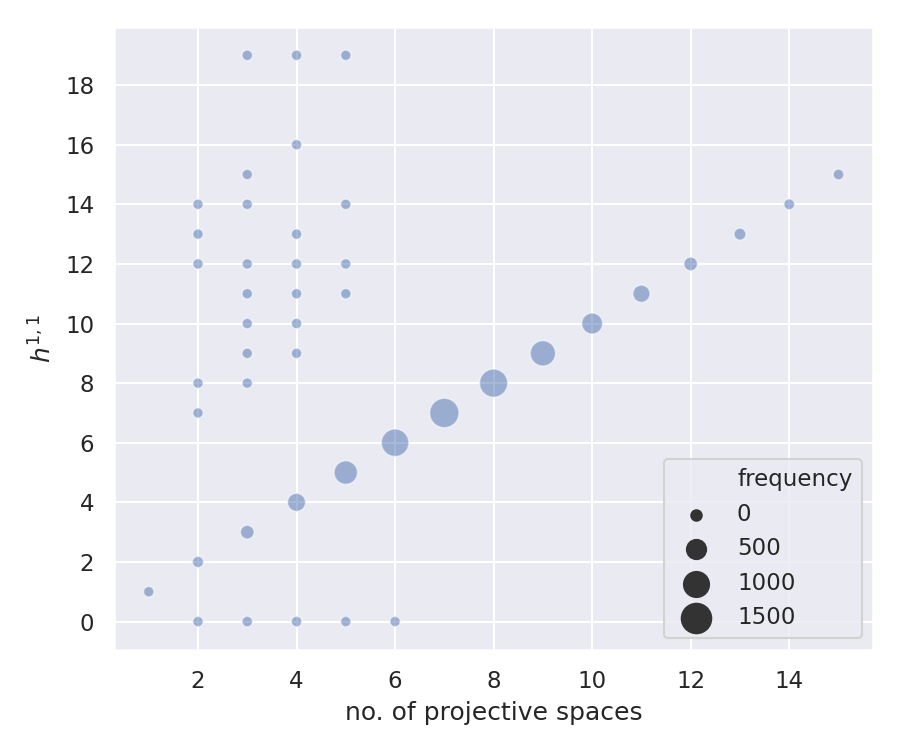

In [13]:
from IPython.display import Image

# display the linear relation between h11 and m in the fav. dataset
Image('./img/scat_num_cp_h11_fav.png', width=480)

### Singular Value Decomposition

We compute the Singular Value Decomposition (SVD) to test how many principal components of the matrix retain 99% of the total variance.

In [14]:
!python3 ./scripts/svd.py

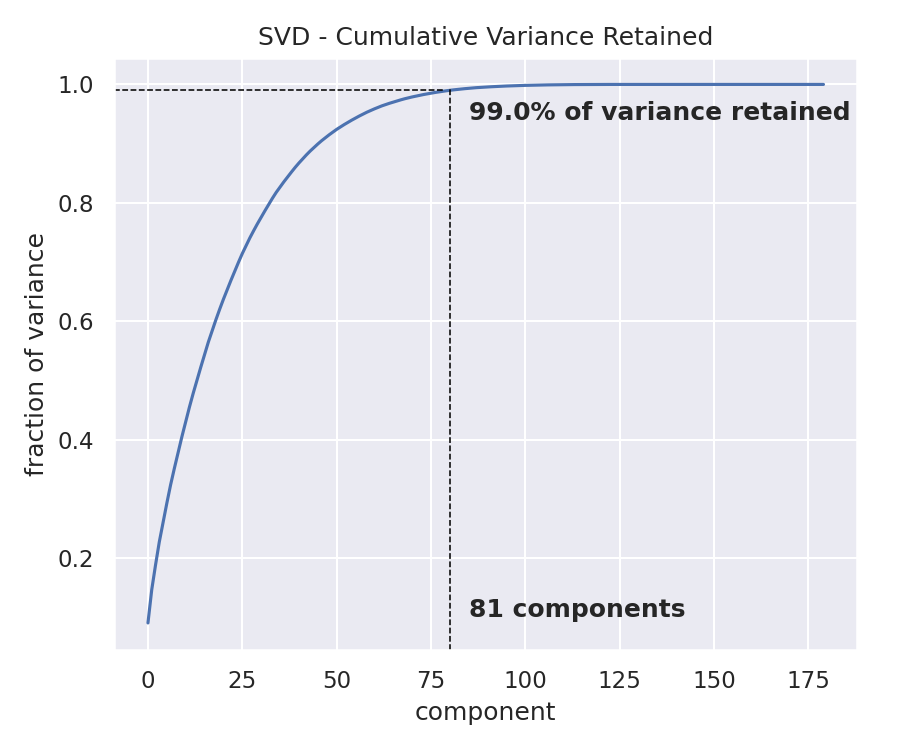

In [15]:
from IPython.display import Image
Image('./img/svd_cum_orig.png', width=480)

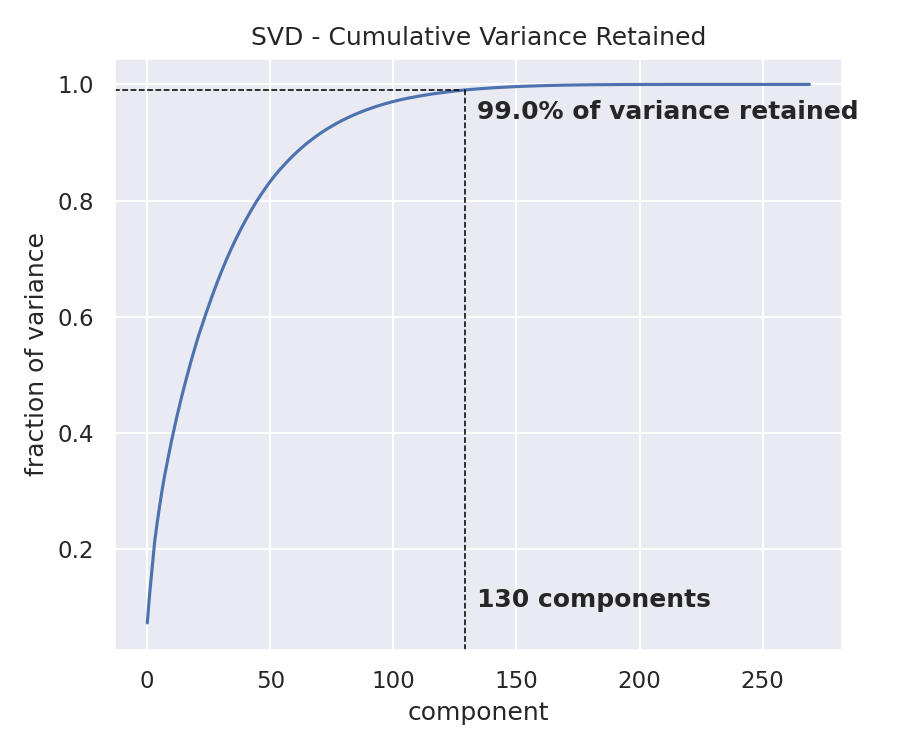

In [16]:
from IPython.display import Image
Image('./img/svd_cum_fav.png', width=480)

### Principal Components Analysis

We study the Principal Components Analysis (PCA) of the entries of the matrix.

In [17]:
# set the random seed
RAND = 42

In [18]:
!python3 ./scripts/pca.py --rand {RAND}

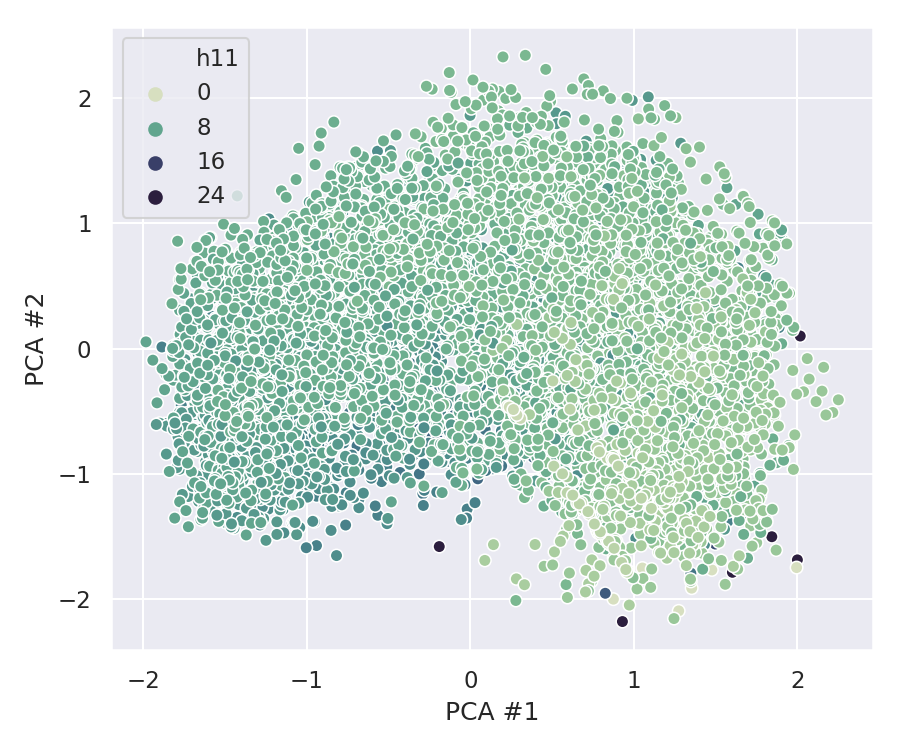

In [19]:
from IPython.display import Image

# display the distribution of h11 with the PCA in the orig. dataset
Image('./img/pca2d_h11_orig.png', width=480)

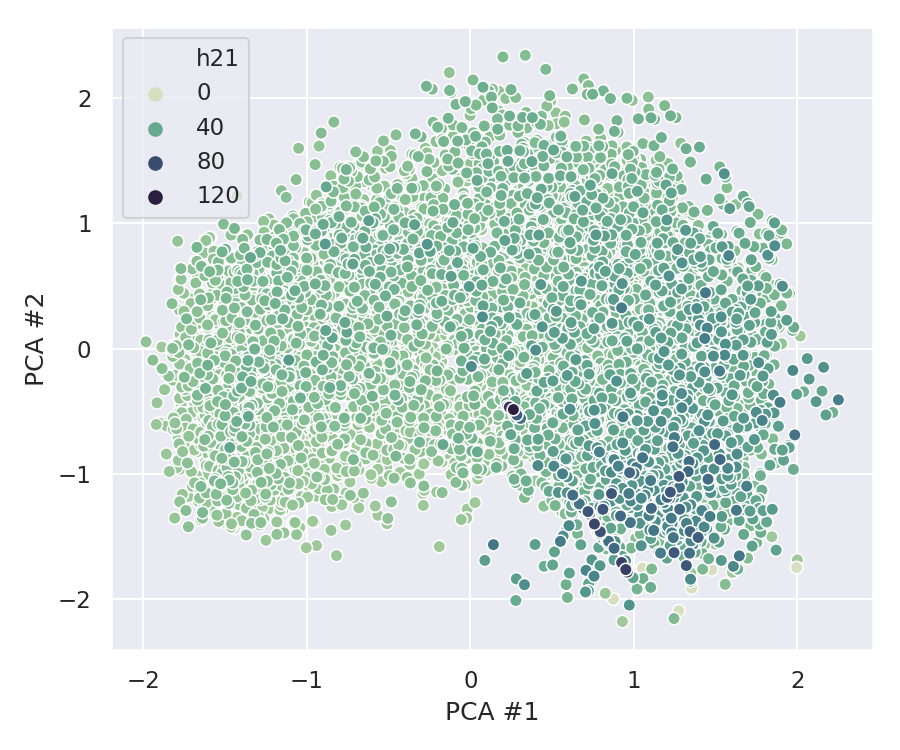

In [20]:
from IPython.display import Image

# display the distribution of h21 with the PCA in the orig. dataset
Image('./img/pca2d_h21_orig.png', width=480)

### K-Means Clustering

We compute the K-Means clustering of the components of the matrix, in case they may help training the algorithms.

In [21]:
# set initial number of clusters
BEGIN = 2
# set ending number of clusters
END   = 15
# set random seed
RAND  = 42

In [22]:
!python3 ./scripts/clustering.py --begin {BEGIN} --end {END} --rand {RAND}

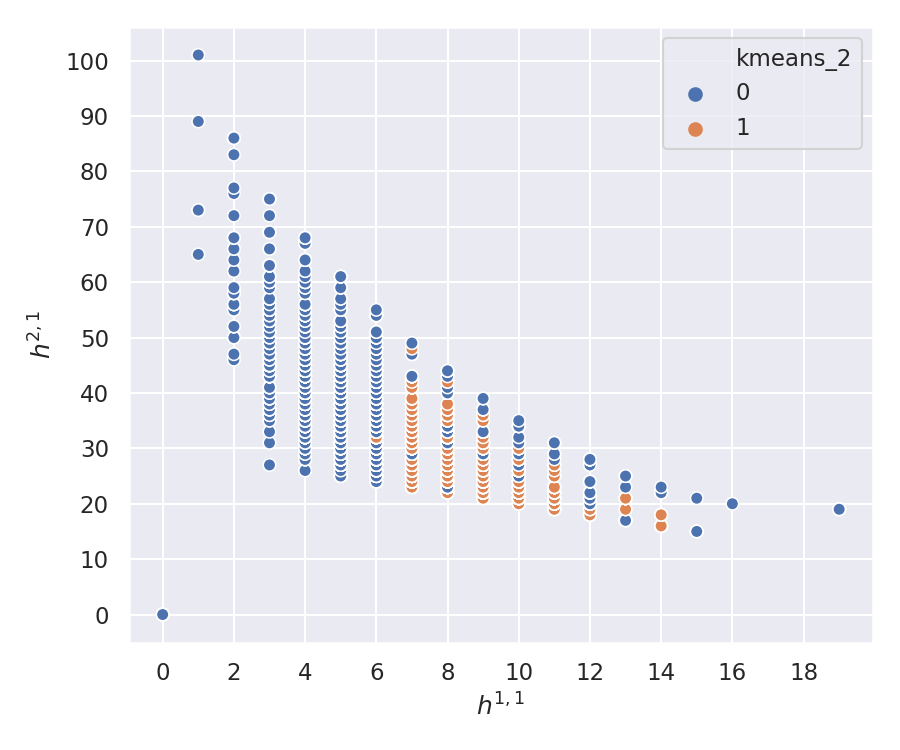

In [23]:
from IPython.display import Image

# display 2 clusters in the original dataset
Image('./img/kmeans_2_orig.png', width=480)

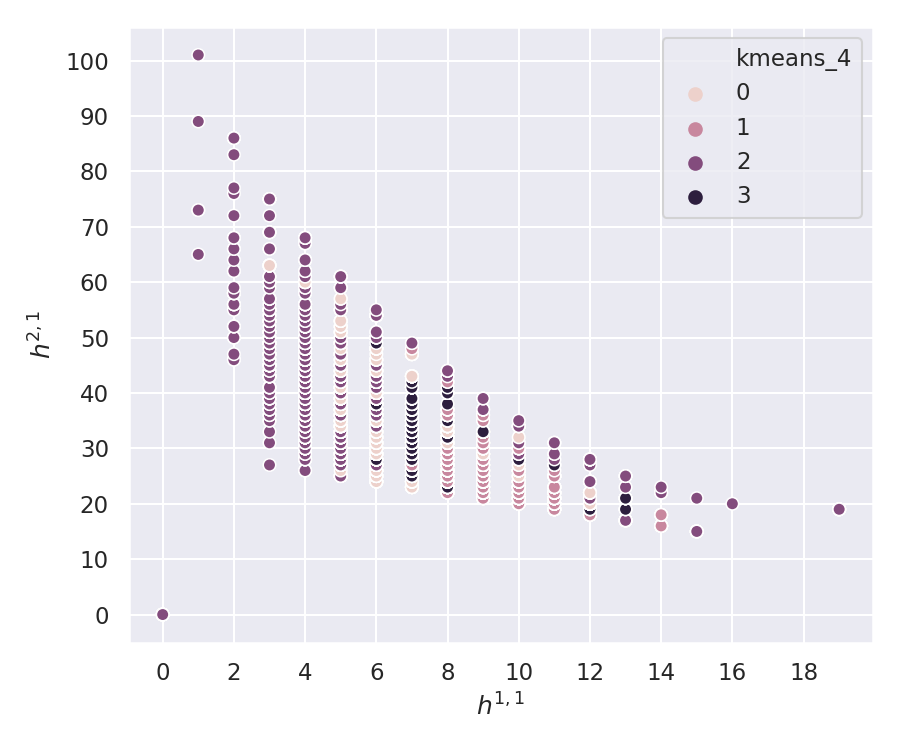

In [24]:
from IPython.display import Image

# display 4 clusters in the original dataset
Image('./img/kmeans_4_orig.png', width=480)

### Feature Importance

We comupute the variable ranking for each feature of the set (since the set is complete we do not split the set into training and test since this is a qualitative study of the variable ranking).

In [25]:
import pandas as pd

# prepare the features for the input
df_o        = pd.read_csv('./data/cicy3o_tidy.csv')
df_f        = pd.read_csv('./data/cicy3f_tidy.csv')
df_o_pca    = pd.read_csv('./data/cicy3o_pca.csv')
df_f_pca    = pd.read_csv('./data/cicy3f_pca.csv')
df_o_kmeans = pd.read_csv('./data/cicy3o_kmeans.csv')
df_f_kmeans = pd.read_csv('./data/cicy3f_kmeans.csv')

# columns to drop (they vary between the datasets)
col_o_drop = df_o.filter(regex='euler|^c2.*|^is.*|^fav.*|^size.*|^redun.*|^kahl.*').columns
col_f_drop = df_f.filter(regex='euler|^c2.*|^is.*|^fav.*|^size.*|^redun.*|^kahl.*').columns

mat_o_drop = df_o.filter(regex='^matrix_.*').columns
mat_f_drop = df_f.filter(regex='^matrix_.*').columns

# drop the columns and join the clusters
mat_o = df_o.drop(columns=col_o_drop).drop(columns=['h11', 'h21']).join(df_o_kmeans)
mat_f = df_f.drop(columns=col_f_drop).drop(columns=['h11', 'h21']).join(df_f_kmeans)

mat_o.to_csv('./data/var_rank_mat_o.csv', index=False)
mat_f.to_csv('./data/var_rank_mat_f.csv', index=False)

# drop the columns and the matrix, and join the clusters and the pca
pca_o = mat_o.drop(columns=mat_o_drop).join(df_o_pca)
pca_f = mat_f.drop(columns=mat_f_drop).join(df_f_pca)

pca_o.to_csv('./data/var_rank_pca_o.csv', index=False)
pca_f.to_csv('./data/var_rank_pca_f.csv', index=False)

After preparing the input we also prepare the estimator and its hyperparameters for training.

In [26]:
from sklearn.ensemble import RandomForestRegressor
import joblib
import json
import os

# set seed
RAND = 42

# prepare the estimator for training
estimator   = RandomForestRegressor(random_state=RAND, n_jobs=-1)
hyperparams = {'n_estimators': 100,
               'criterion': 'mse'
              }

# save to file (one for each needed model)
os.makedirs('./models', exist_ok=True)

joblib.dump(estimator, './models/rnd_for_var_rank_h11_mat_o.pkl')
joblib.dump(estimator, './models/rnd_for_var_rank_h11_pca_o.pkl')
joblib.dump(estimator, './models/rnd_for_var_rank_h11_mat_f.pkl')
joblib.dump(estimator, './models/rnd_for_var_rank_h11_pca_f.pkl')
joblib.dump(estimator, './models/rnd_for_var_rank_h21_mat_o.pkl')
joblib.dump(estimator, './models/rnd_for_var_rank_h21_pca_o.pkl')
joblib.dump(estimator, './models/rnd_for_var_rank_h21_mat_f.pkl')
joblib.dump(estimator, './models/rnd_for_var_rank_h21_pca_f.pkl')

with open('./models/rnd_for_var_rank_hypers.json', 'w') as f:
    json.dump(hyperparams, f)

We then train the model:

In [27]:
!python3 ./scripts/train.py --rand {RAND} \
                            --name 'Variable Ranking (h11, matrix, orig. dataset)' \
                            --estimator ./models/rnd_for_var_rank_h11_mat_o.pkl \
                            --hyperparams ./models/rnd_for_var_rank_hypers.json \
                            --features ./data/var_rank_mat_o.csv \
                            --labels ./data/h11.csv

!python3 ./scripts/train.py --rand {RAND} \
                            --name 'Variable Ranking (h11, PCA, orig. dataset)' \
                            --estimator ./models/rnd_for_var_rank_h11_pca_o.pkl \
                            --hyperparams ./models/rnd_for_var_rank_hypers.json \
                            --features ./data/var_rank_pca_o.csv \
                            --labels ./data/h11.csv

!python3 ./scripts/train.py --rand {RAND} \
                            --name 'Variable Ranking (h11, matrix, fav. dataset)' \
                            --estimator ./models/rnd_for_var_rank_h11_mat_f.pkl \
                            --hyperparams ./models/rnd_for_var_rank_hypers.json \
                            --features ./data/var_rank_mat_f.csv \
                            --labels ./data/h11.csv

!python3 ./scripts/train.py --rand {RAND} \
                            --name 'Variable Ranking (h11, PCA, fav. dataset)' \
                            --estimator ./models/rnd_for_var_rank_h11_pca_f.pkl \
                            --hyperparams ./models/rnd_for_var_rank_hypers.json \
                            --features ./data/var_rank_pca_f.csv \
                            --labels ./data/h11.csv

!python3 ./scripts/train.py --rand {RAND} \
                            --name 'Variable Ranking (h21, matrix, orig. dataset)' \
                            --estimator ./models/rnd_for_var_rank_h21_mat_o.pkl \
                            --hyperparams ./models/rnd_for_var_rank_hypers.json \
                            --features ./data/var_rank_mat_o.csv \
                            --labels ./data/h21.csv

!python3 ./scripts/train.py --rand {RAND} \
                            --name 'Variable Ranking (h21, PCA, orig. dataset)' \
                            --estimator ./models/rnd_for_var_rank_h21_pca_o.pkl \
                            --hyperparams ./models/rnd_for_var_rank_hypers.json \
                            --features ./data/var_rank_pca_o.csv \
                            --labels ./data/h21.csv

!python3 ./scripts/train.py --rand {RAND} \
                            --name 'Variable Ranking (h21, matrix, fav. dataset)' \
                            --estimator ./models/rnd_for_var_rank_h21_mat_f.pkl \
                            --hyperparams ./models/rnd_for_var_rank_hypers.json \
                            --features ./data/var_rank_mat_f.csv \
                            --labels ./data/h21.csv

!python3 ./scripts/train.py --rand {RAND} \
                            --name 'Variable Ranking (h21, PCA, fav. dataset)' \
                            --estimator ./models/rnd_for_var_rank_h21_pca_f.pkl \
                            --hyperparams ./models/rnd_for_var_rank_hypers.json \
                            --features ./data/var_rank_pca_f.csv \
                            --labels ./data/h21.csv

Variable Ranking (h11, matrix, orig. dataset) trained in 0.54 seconds.
Variable Ranking (h11, matrix, orig. dataset) saved to ./models/rnd_for_var_rank_h11_mat_o.pkl
Variable Ranking (h11, PCA, orig. dataset) trained in 2.68 seconds.
Variable Ranking (h11, PCA, orig. dataset) saved to ./models/rnd_for_var_rank_h11_pca_o.pkl
Variable Ranking (h11, matrix, fav. dataset) trained in 0.25 seconds.
Variable Ranking (h11, matrix, fav. dataset) saved to ./models/rnd_for_var_rank_h11_mat_f.pkl
Variable Ranking (h11, PCA, fav. dataset) trained in 1.51 seconds.
Variable Ranking (h11, PCA, fav. dataset) saved to ./models/rnd_for_var_rank_h11_pca_f.pkl
Variable Ranking (h21, matrix, orig. dataset) trained in 0.68 seconds.
Variable Ranking (h21, matrix, orig. dataset) saved to ./models/rnd_for_var_rank_h21_mat_o.pkl
Variable Ranking (h21, PCA, orig. dataset) trained in 2.65 seconds.
Variable Ranking (h21, PCA, orig. dataset) saved to ./models/rnd_for_var_rank_h21_pca_o.pkl
Variable Ranking (h21, mat

We can then extract the feature importances:

In [28]:
import joblib
import pandas as pd

# load the trained estimators
h11_mat_o_est = joblib.load('./models/rnd_for_var_rank_h11_mat_o.pkl')
h11_pca_o_est = joblib.load('./models/rnd_for_var_rank_h11_pca_o.pkl')
h11_mat_f_est = joblib.load('./models/rnd_for_var_rank_h11_mat_f.pkl')
h11_pca_f_est = joblib.load('./models/rnd_for_var_rank_h11_pca_f.pkl')
h21_mat_o_est = joblib.load('./models/rnd_for_var_rank_h21_mat_o.pkl')
h21_pca_o_est = joblib.load('./models/rnd_for_var_rank_h21_pca_o.pkl')
h21_mat_f_est = joblib.load('./models/rnd_for_var_rank_h21_mat_f.pkl')
h21_pca_f_est = joblib.load('./models/rnd_for_var_rank_h21_pca_f.pkl')

# extract the variable ranking
h11_mat_o_rank = h11_mat_o_est.feature_importances_
h11_pca_o_rank = h11_pca_o_est.feature_importances_
h11_mat_f_rank = h11_mat_f_est.feature_importances_
h11_pca_f_rank = h11_pca_f_est.feature_importances_
h21_mat_o_rank = h21_mat_o_est.feature_importances_
h21_pca_o_rank = h21_pca_o_est.feature_importances_
h21_mat_f_rank = h21_mat_f_est.feature_importances_
h21_pca_f_rank = h21_pca_f_est.feature_importances_

# zip the lists with their names
mat_o_rank = pd.DataFrame(list(zip(mat_o.columns, h11_mat_o_rank, h21_mat_o_rank)),
                          columns=['feature', 'h11', 'h21']
                         ).melt(id_vars=['feature'], var_name='hodge')
pca_o_rank = pd.DataFrame(list(zip(pca_o.columns, h11_pca_o_rank, h21_pca_o_rank)),
                          columns=['feature', 'h11', 'h21']
                         ).melt(id_vars=['feature'], var_name='hodge')
mat_f_rank = pd.DataFrame(list(zip(mat_f.columns, h11_mat_f_rank, h21_mat_f_rank)),
                          columns=['feature', 'h11', 'h21']
                         ).melt(id_vars=['feature'], var_name='hodge')
pca_f_rank = pd.DataFrame(list(zip(pca_f.columns, h11_pca_f_rank, h21_pca_f_rank)),
                          columns=['feature', 'h11', 'h21']
                         ).melt(id_vars=['feature'], var_name='hodge')

We are now in the position to differentiate each feature:

In [29]:
# find scalar, vector and tensor features
scal_mat_o = mat_o_rank.loc[(~mat_o_rank['feature'].str.contains('.*_[0-9]*$')) | 
                            (mat_o_rank['feature'].str.contains('^num_cp'))
                           ]
scal_mat_o.to_csv('./data/scal_mat_o.csv', index=False)
scal_pca_o = pca_o_rank.loc[(~pca_o_rank['feature'].str.contains('.*_[0-9]*$')) | 
                            (pca_o_rank['feature'].str.contains('^num_cp'))
                           ]
scal_pca_o.to_csv('./data/scal_pca_o.csv', index=False)
scal_mat_f = mat_f_rank.loc[(~mat_f_rank['feature'].str.contains('.*_[0-9]*$')) | 
                            (mat_f_rank['feature'].str.contains('^num_cp'))
                           ]
scal_mat_f.to_csv('./data/scal_mat_f.csv', index=False)
scal_pca_f = pca_f_rank.loc[(~pca_f_rank['feature'].str.contains('.*_[0-9]*$')) | 
                            (pca_f_rank['feature'].str.contains('^num_cp'))
                           ]
scal_pca_f.to_csv('./data/scal_pca_f.csv', index=False)


vect_mat_o = mat_o_rank.loc[(mat_o_rank['feature'].str.contains('.*_[0-9]*$')) & 
                            (~mat_o_rank['feature'].str.contains('^num_cp')) & 
                            (~mat_o_rank['feature'].str.contains('^kmeans_'))
                        ].replace(to_replace=r'(.*)_[0-9]*$', value=r'\1', regex=True)
vect_mat_o.to_csv('./data/vect_mat_o.csv', index=False)
vect_pca_o = pca_o_rank.loc[(pca_o_rank['feature'].str.contains('.*_[0-9]*$')) & 
                            (~pca_o_rank['feature'].str.contains('^num_cp')) & 
                            (~pca_o_rank['feature'].str.contains('^kmeans_'))
                           ].replace(to_replace=r'(.*)_[0-9]*$', value=r'\1', regex=True)
vect_pca_o.to_csv('./data/vect_pca_o.csv', index=False)
vect_mat_f = mat_f_rank.loc[(mat_f_rank['feature'].str.contains('.*_[0-9]*$')) & 
                            (~mat_f_rank['feature'].str.contains('^num_cp')) & 
                            (~mat_f_rank['feature'].str.contains('^kmeans_'))
                           ].replace(to_replace=r'(.*)_[0-9]*$', value=r'\1', regex=True)
vect_mat_f.to_csv('./data/vect_mat_f.csv', index=False)
vect_pca_f = pca_f_rank.loc[(pca_f_rank['feature'].str.contains('.*_[0-9]*$')) & 
                            (~pca_f_rank['feature'].str.contains('^num_cp')) & 
                            (~pca_f_rank['feature'].str.contains('^kmeans_'))
                           ].replace(to_replace=r'(.*)_[0-9]*$', value=r'\1', regex=True)
vect_pca_f.to_csv('./data/vect_pca_f.csv', index=False)

clus_mat_o = mat_o_rank.\
             loc[mat_o_rank['feature'].str.contains('^kmeans_')].\
             replace(to_replace=r'.*_([0-9]*)$', value=r'\1 clusters', regex=True)
clus_mat_o.to_csv('./data/clus_mat_o.csv', index=False)
clus_pca_o = pca_o_rank.\
             loc[pca_o_rank['feature'].str.contains('^kmeans_')].\
             replace(to_replace=r'.*_([0-9]*)$', value=r'\1 clusters', regex=True)
clus_pca_o.to_csv('./data/clus_pca_o.csv', index=False)
clus_mat_f = mat_f_rank.\
             loc[mat_f_rank['feature'].str.contains('^kmeans_')].\
             replace(to_replace=r'.*_([0-9]*)$', value=r'\1 clusters', regex=True)
clus_mat_f.to_csv('./data/clus_mat_f.csv', index=False)
clus_pca_f = pca_f_rank.\
             loc[pca_f_rank['feature'].str.contains('^kmeans_')].\
             replace(to_replace=r'.*_([0-9]*)$', value=r'\1 clusters', regex=True)
clus_pca_f.to_csv('./data/clus_pca_f.csv', index=False)

We finally plot the different kinds of features against each other:

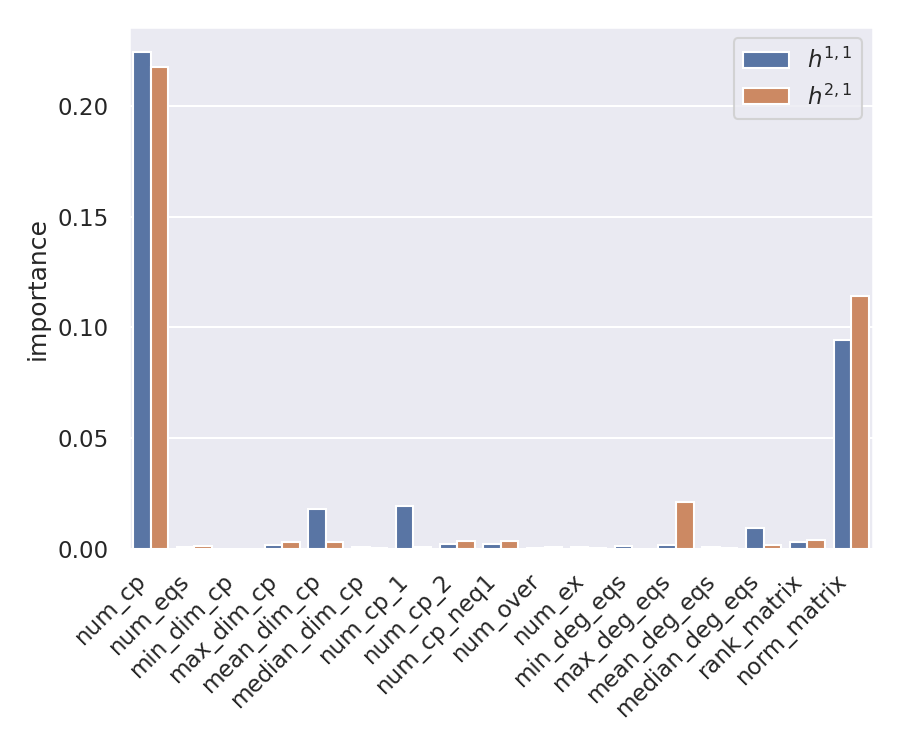

In [30]:
from IPython.display import Image

INPUT  = './data/scal_mat_o.csv'
OUTPUT = 'var_rank_scal_mat_o'

!python3 ./scripts/var_rank_plot.py --in {INPUT} --out {OUTPUT}
Image('./img/{}.png'.format(OUTPUT), width=480)

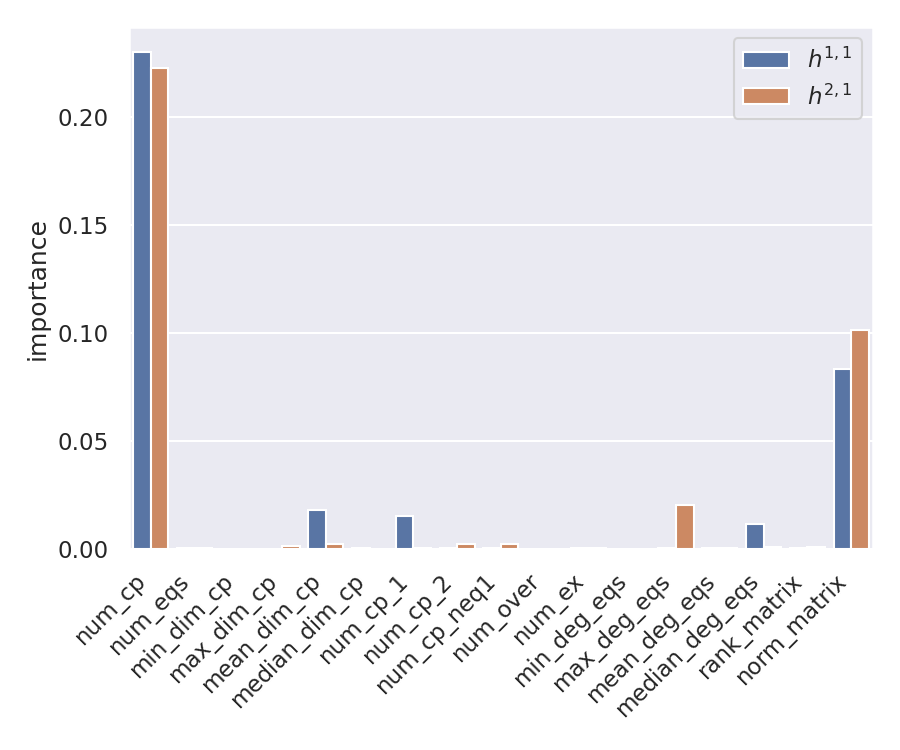

In [31]:
from IPython.display import Image

INPUT  = './data/scal_pca_o.csv'
OUTPUT = 'var_rank_scal_pca_o'

!python3 ./scripts/var_rank_plot.py --in {INPUT} --out {OUTPUT}
Image('./img/{}.png'.format(OUTPUT), width=480)

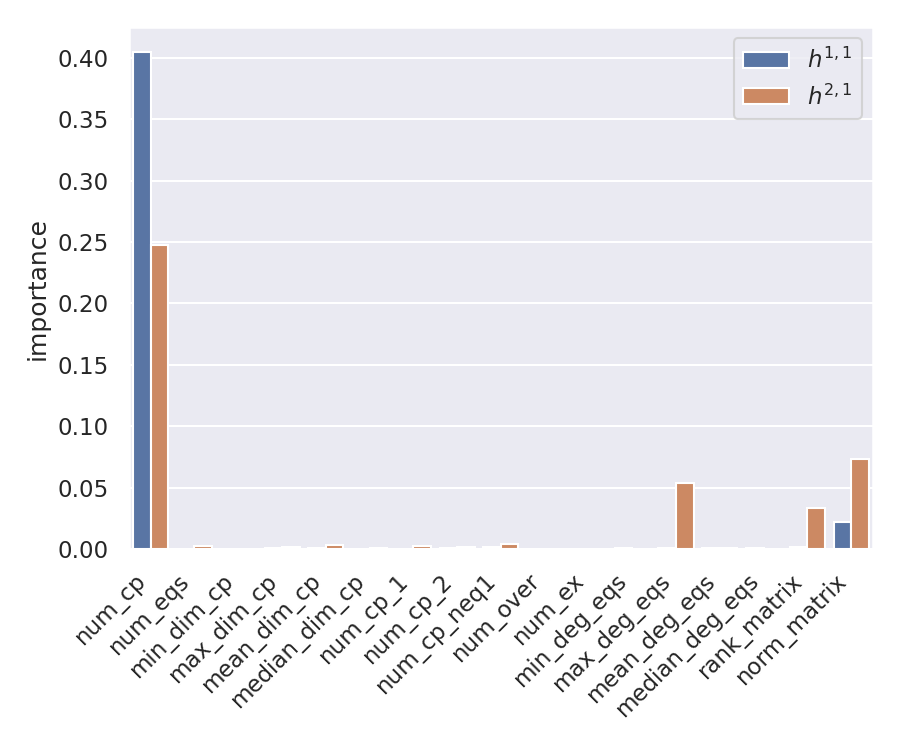

In [32]:
from IPython.display import Image

INPUT  = './data/scal_mat_f.csv'
OUTPUT = 'var_rank_scal_mat_f'

!python3 ./scripts/var_rank_plot.py --in {INPUT} --out {OUTPUT}
Image('./img/{}.png'.format(OUTPUT), width=480)

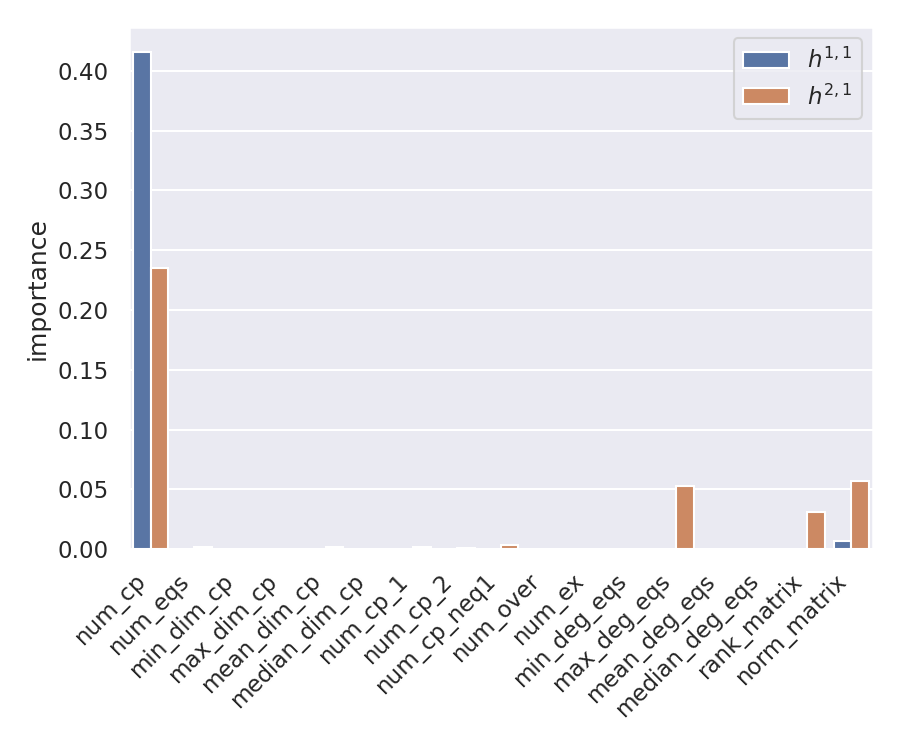

In [33]:
from IPython.display import Image

INPUT  = './data/scal_pca_f.csv'
OUTPUT = 'var_rank_scal_pca_f'

!python3 ./scripts/var_rank_plot.py --in {INPUT} --out {OUTPUT}
Image('./img/{}.png'.format(OUTPUT), width=480)

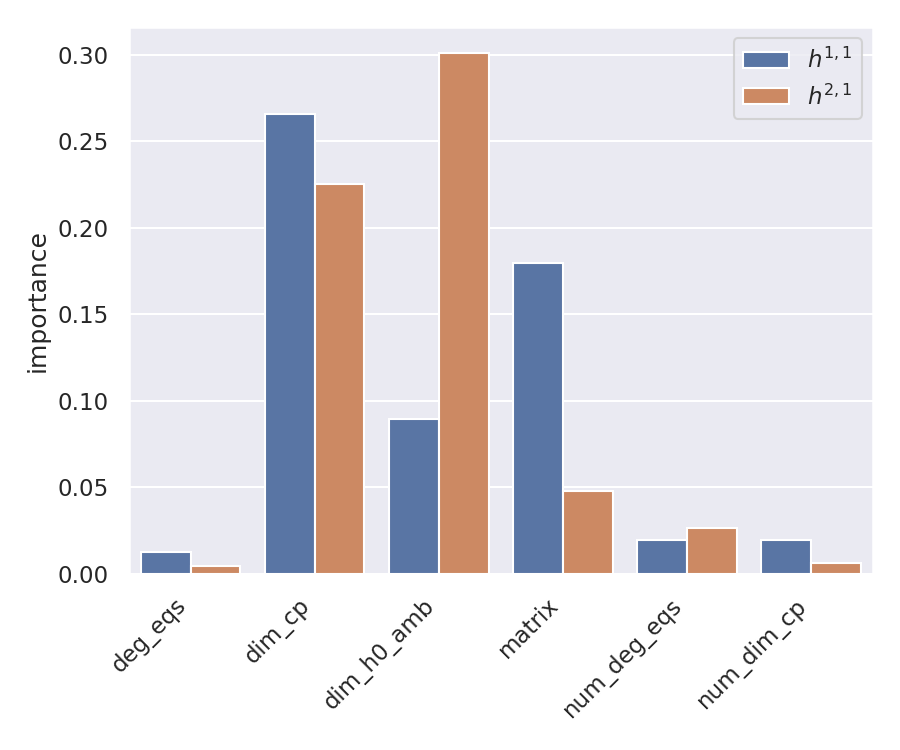

In [34]:
from IPython.display import Image

INPUT  = './data/vect_mat_o.csv'
OUTPUT = 'var_rank_vect_mat_o'

!python3 ./scripts/var_rank_plot.py --in {INPUT} --out {OUTPUT} --group
Image('./img/{}.png'.format(OUTPUT), width=480)

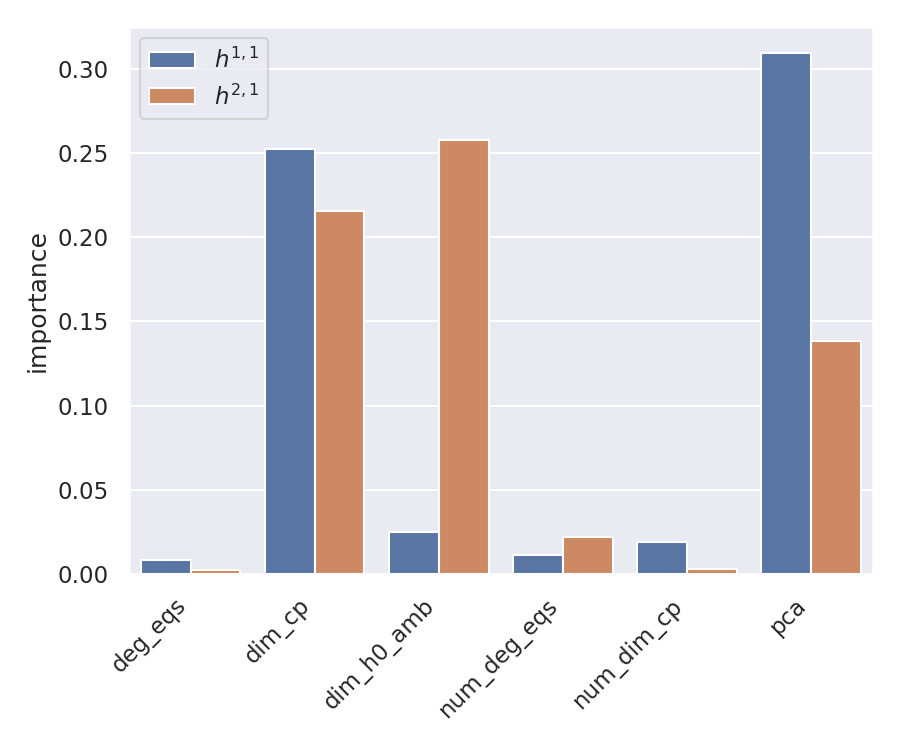

In [35]:
from IPython.display import Image

INPUT  = './data/vect_pca_o.csv'
OUTPUT = 'var_rank_vect_pca_o'

!python3 ./scripts/var_rank_plot.py --in {INPUT} --out {OUTPUT} --group
Image('./img/{}.png'.format(OUTPUT), width=480)

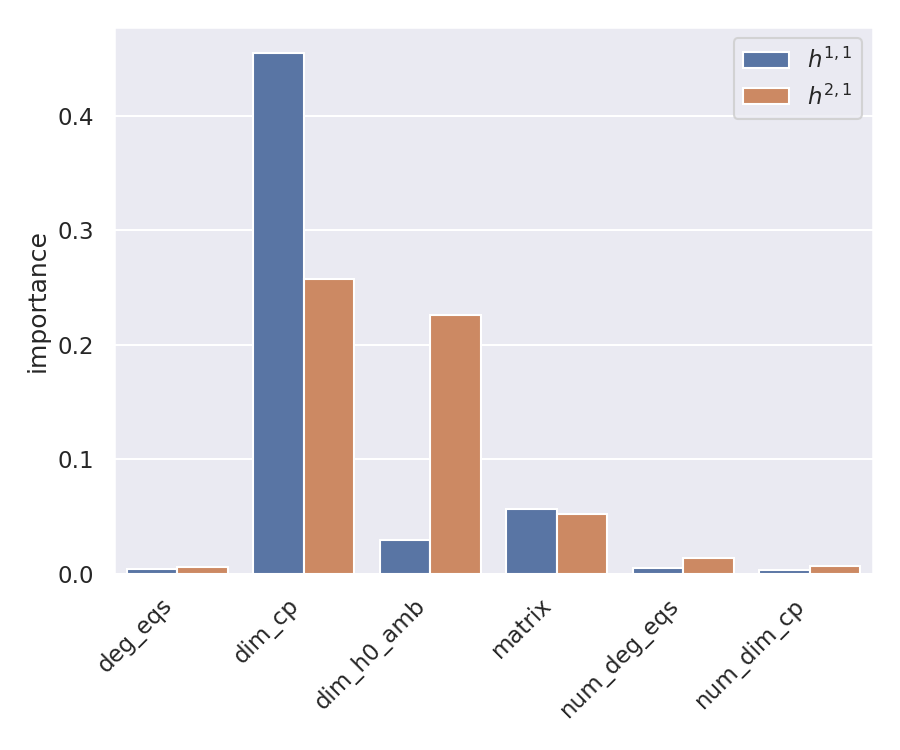

In [36]:
from IPython.display import Image

INPUT  = './data/vect_mat_f.csv'
OUTPUT = 'var_rank_vect_mat_f'

!python3 ./scripts/var_rank_plot.py --in {INPUT} --out {OUTPUT} --group
Image('./img/{}.png'.format(OUTPUT), width=480)

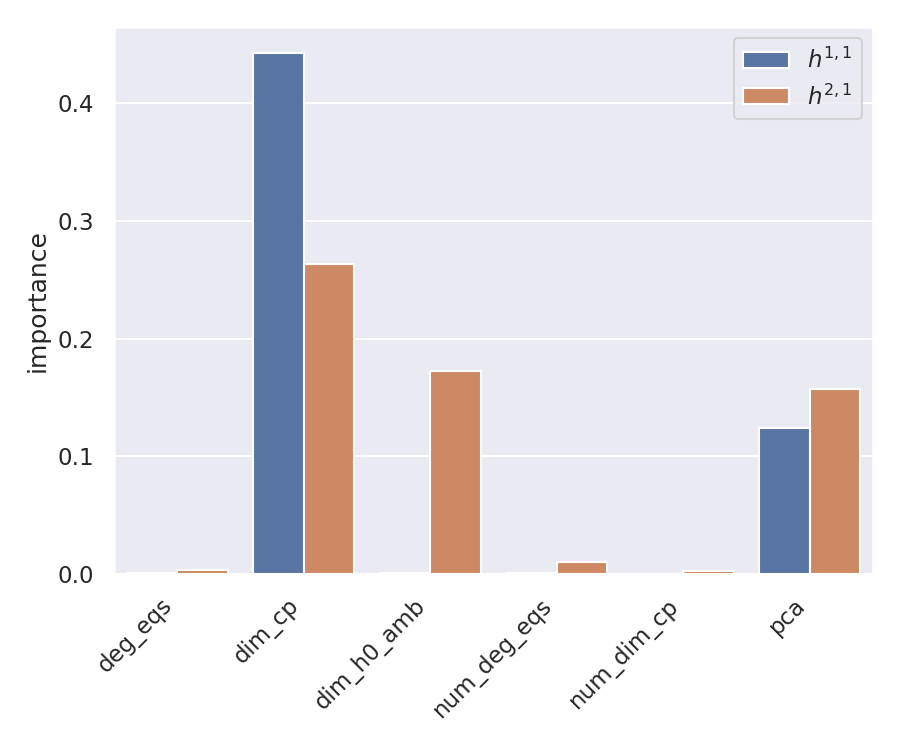

In [37]:
from IPython.display import Image

INPUT  = './data/vect_pca_f.csv'
OUTPUT = 'var_rank_vect_pca_f'

!python3 ./scripts/var_rank_plot.py --in {INPUT} --out {OUTPUT} --group
Image('./img/{}.png'.format(OUTPUT), width=480)

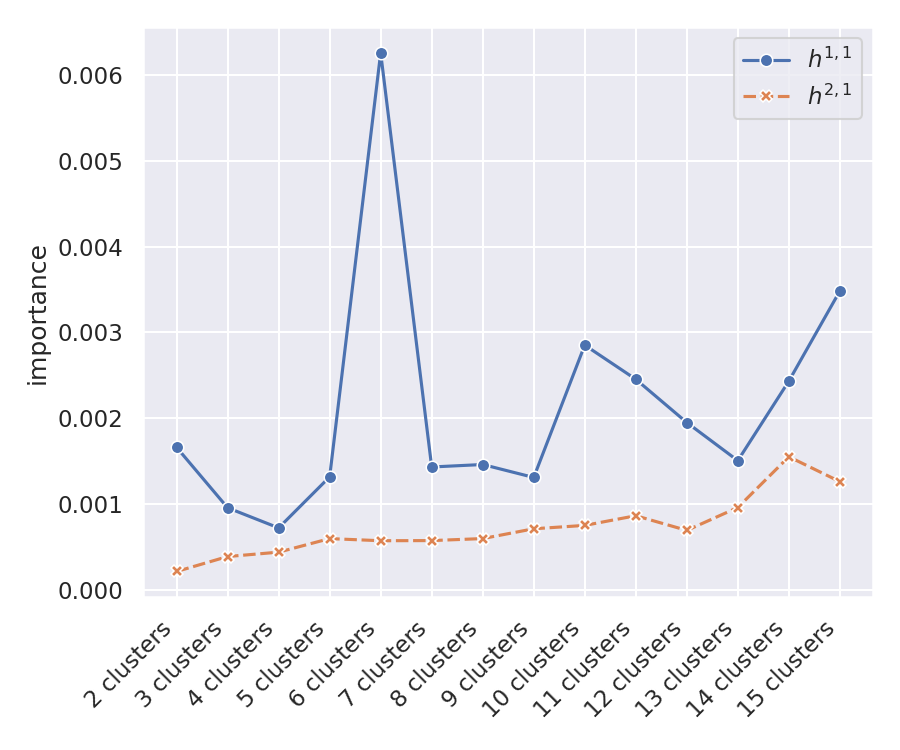

In [38]:
from IPython.display import Image

INPUT  = './data/clus_mat_o.csv'
OUTPUT = 'var_rank_clus_mat_o'

!python3 ./scripts/var_rank_clus_plot.py --in {INPUT} --out {OUTPUT}
Image('./img/{}.png'.format(OUTPUT), width=480)

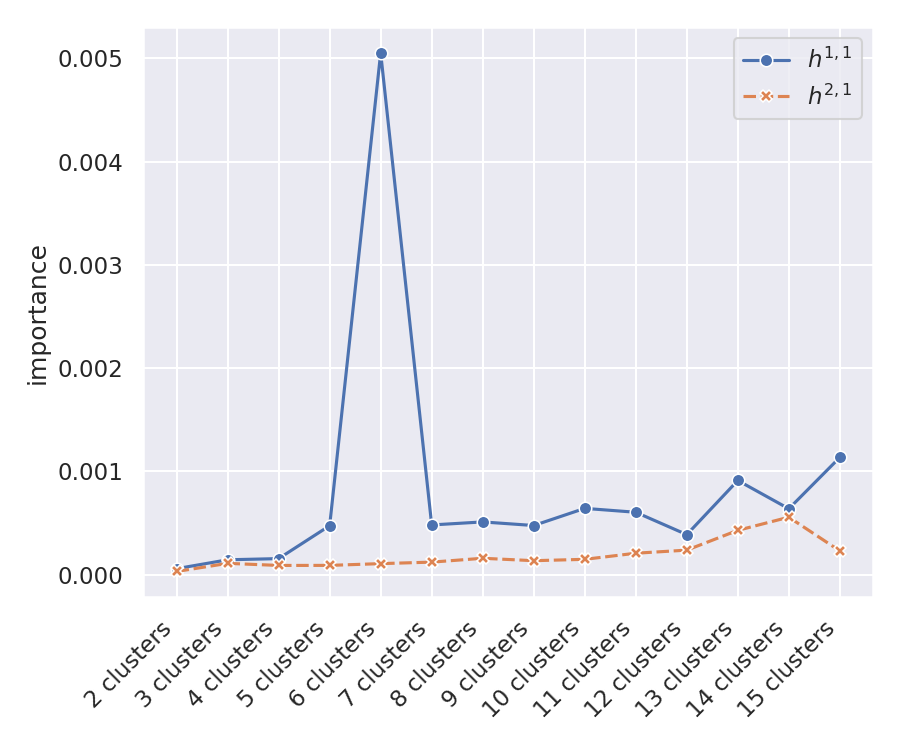

In [39]:
from IPython.display import Image

INPUT  = './data/clus_pca_o.csv'
OUTPUT = 'var_rank_clus_pca_o'

!python3 ./scripts/var_rank_clus_plot.py --in {INPUT} --out {OUTPUT}
Image('./img/{}.png'.format(OUTPUT), width=480)

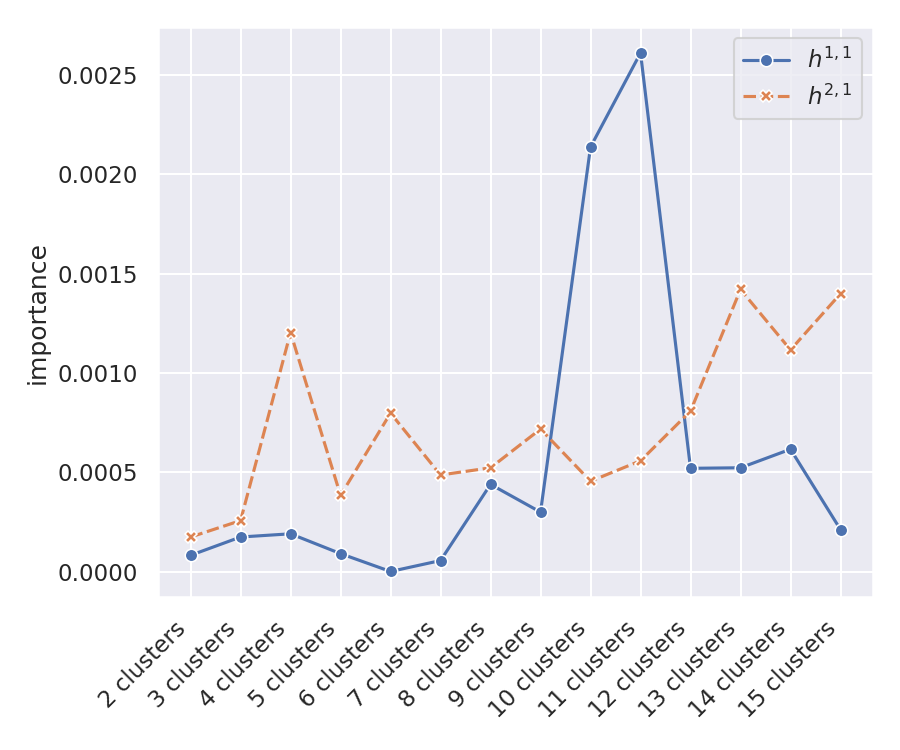

In [40]:
from IPython.display import Image

INPUT  = './data/clus_mat_f.csv'
OUTPUT = 'var_rank_clus_mat_f'

!python3 ./scripts/var_rank_clus_plot.py --in {INPUT} --out {OUTPUT}
Image('./img/{}.png'.format(OUTPUT), width=480)

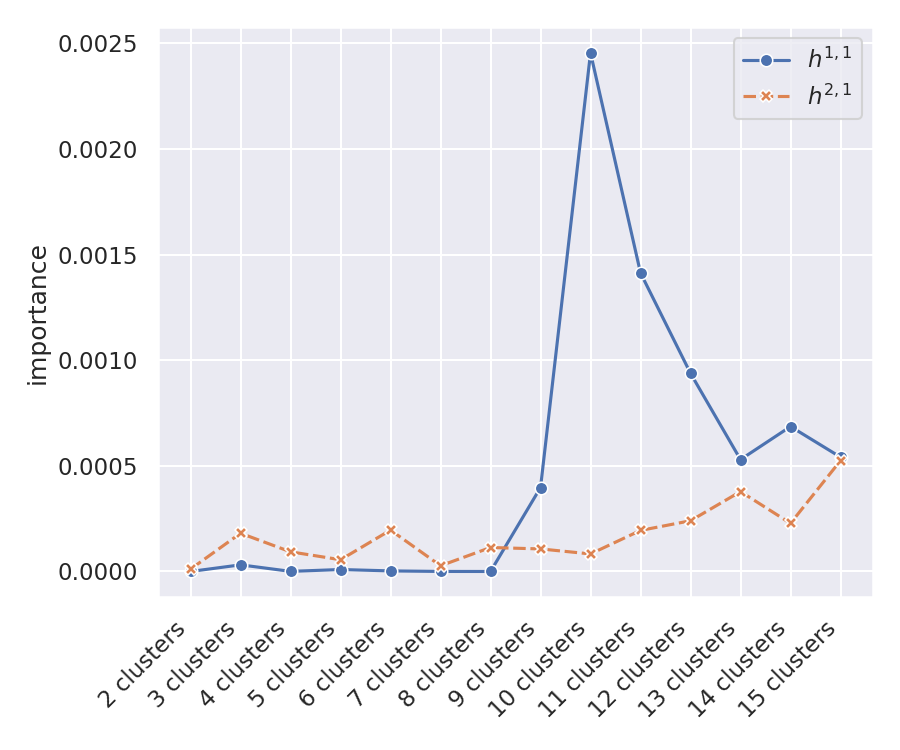

In [41]:
from IPython.display import Image

INPUT  = './data/clus_pca_f.csv'
OUTPUT = 'var_rank_clus_pca_f'

!python3 ./scripts/var_rank_clus_plot.py --in {INPUT} --out {OUTPUT}
Image('./img/{}.png'.format(OUTPUT), width=480)